# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.21KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

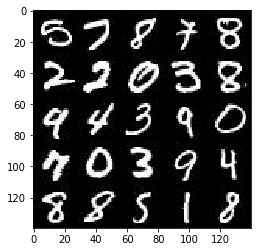

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

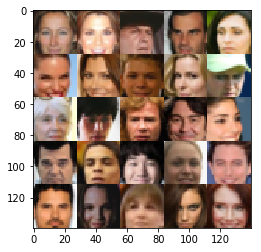

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
    
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):

        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 8.8204... Generator Loss: 0.0002
Epoch 1/2... Discriminator Loss: 0.0913... Generator Loss: 3.8997
Epoch 1/2... Discriminator Loss: 0.2315... Generator Loss: 7.5463
Epoch 1/2... Discriminator Loss: 0.5160... Generator Loss: 2.3272
Epoch 1/2... Discriminator Loss: 0.2855... Generator Loss: 5.3670
Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 2.4822
Epoch 1/2... Discriminator Loss: 0.1997... Generator Loss: 2.9869
Epoch 1/2... Discriminator Loss: 0.3683... Generator Loss: 5.7946
Epoch 1/2... Discriminator Loss: 1.7401... Generator Loss: 7.2488
Epoch 1/2... Discriminator Loss: 0.4517... Generator Loss: 2.1004


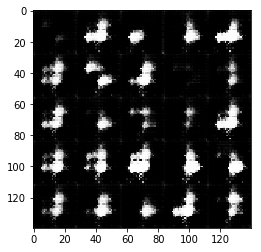

Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 5.2843
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.5103
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 3.7475
Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 2.6309
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.1562
Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 1.3918
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.3758
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.7745
Epoch 1/2... Discriminator Loss: 1.7304... Generator Loss: 0.3809


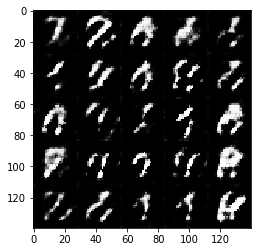

Epoch 1/2... Discriminator Loss: 0.8691... Generator Loss: 1.2565
Epoch 1/2... Discriminator Loss: 0.4588... Generator Loss: 1.9937
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 2.0722... Generator Loss: 4.7102
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 1.5216
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 0.9561
Epoch 1/2... Discriminator Loss: 0.4998... Generator Loss: 2.1569
Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 2.2721
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 3.4755


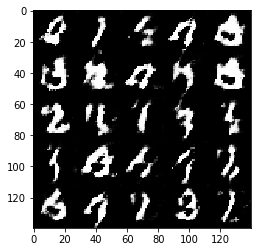

Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.9026
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.2711
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 1.3249
Epoch 1/2... Discriminator Loss: 0.7939... Generator Loss: 1.3712
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 2.3555
Epoch 1/2... Discriminator Loss: 1.5188... Generator Loss: 5.0759
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 2.1294
Epoch 1/2... Discriminator Loss: 0.7779... Generator Loss: 1.3646


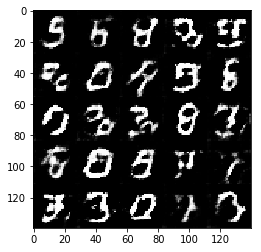

Epoch 1/2... Discriminator Loss: 0.5822... Generator Loss: 1.4582
Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 1.6367
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 4.1754
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 2.1086
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 3.2168
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 2.1681


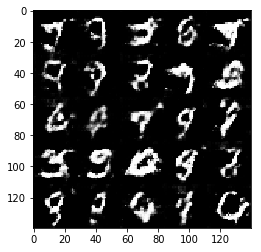

Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 2.1847
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 2.3432
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.6473
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 1.7957
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 0.9317
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.9070
Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 0.9542


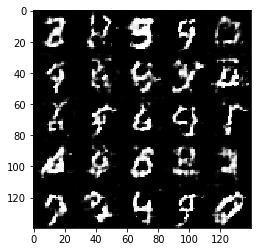

Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.4061
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.3650
Epoch 1/2... Discriminator Loss: 1.9504... Generator Loss: 0.2941
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 2.4592
Epoch 1/2... Discriminator Loss: 0.9220... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 2.2682
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.3037
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 0.8090


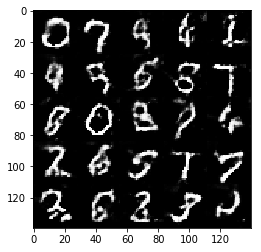

Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.4670
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.6862... Generator Loss: 0.2814
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.5660
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 2.3313
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 1.8699
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.3970


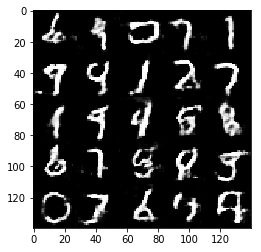

Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 1.5408
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 1.8312
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.0835
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.7380
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.4892


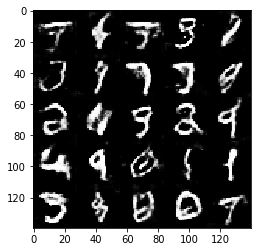

Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.8106
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.4578
Epoch 2/2... Discriminator Loss: 2.1795... Generator Loss: 0.2242
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.4069
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 1.9809
Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 3.1989... Generator Loss: 4.2062
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 1.2473


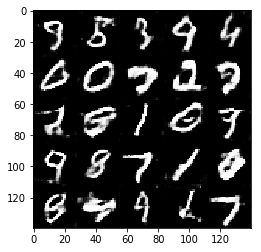

Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.4329
Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 0.3704
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 1.4818
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 1.6646
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.4232


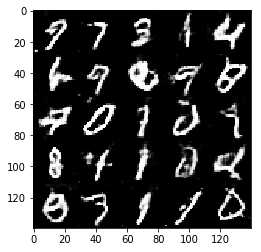

Epoch 2/2... Discriminator Loss: 1.4647... Generator Loss: 2.3556
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 1.8393... Generator Loss: 3.1540
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 0.9615
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.4127
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 2.1580
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.9547
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.8569


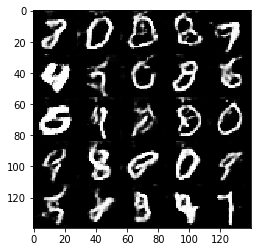

Epoch 2/2... Discriminator Loss: 1.8015... Generator Loss: 0.2926
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 1.9524
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 2.9653... Generator Loss: 4.8241
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.1141


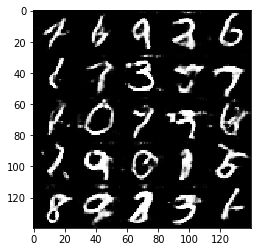

Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 1.6936... Generator Loss: 0.2986
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 1.7182
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.4615
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 0.9177
Epoch 2/2... Discriminator Loss: 1.6396... Generator Loss: 0.2944
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.4627
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.5420
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.6544


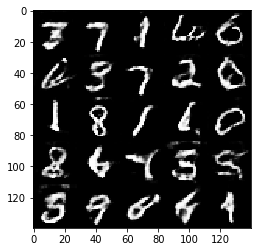

Epoch 2/2... Discriminator Loss: 1.5451... Generator Loss: 0.3526
Epoch 2/2... Discriminator Loss: 1.0738... Generator Loss: 0.8186
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.6507
Epoch 2/2... Discriminator Loss: 1.4917... Generator Loss: 0.3596
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.5206
Epoch 2/2... Discriminator Loss: 0.8324... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 2.0632
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 1.2046
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 2.1321


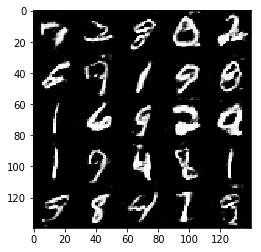

Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.8496
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.6615
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.1012
Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 0.9553
Epoch 2/2... Discriminator Loss: 0.8343... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 1.4628... Generator Loss: 0.3820
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.0671
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 2.8880


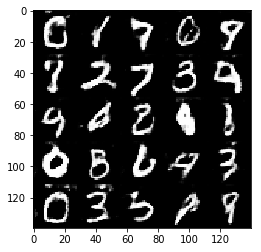

Epoch 2/2... Discriminator Loss: 0.5972... Generator Loss: 1.2356
Epoch 2/2... Discriminator Loss: 1.9986... Generator Loss: 0.2480
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.4364
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.4418
Epoch 2/2... Discriminator Loss: 2.3123... Generator Loss: 0.1710
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 2.3027
Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.5227
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 2.2293


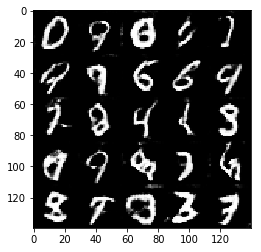

Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.3997
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.6450
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 2.4729... Generator Loss: 4.7090
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.5096
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.9887
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 0.6428... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.1650


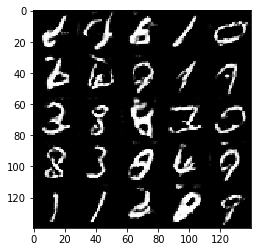

Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 1.8293
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 3.7268
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.8142
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.7570
Epoch 2/2... Discriminator Loss: 1.1003... Generator Loss: 0.6942
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 0.5932
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.5144


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1044... Generator Loss: 4.5285
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 5.0071
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 5.8075
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 0.2303... Generator Loss: 2.4471
Epoch 1/1... Discriminator Loss: 0.2561... Generator Loss: 3.6952
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 2.5643
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 4.5318
Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 3.3973


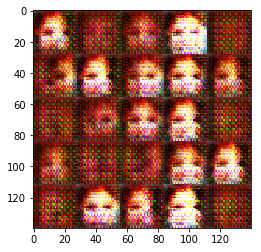

Epoch 1/1... Discriminator Loss: 0.2889... Generator Loss: 2.8769
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 1.5423
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 3.8122
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 4.0366
Epoch 1/1... Discriminator Loss: 1.8818... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 0.1198... Generator Loss: 5.3032
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 1.4735
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.7122


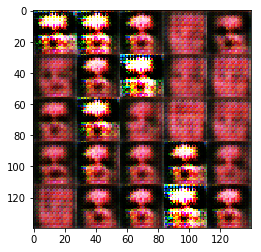

Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 2.2122
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.6323
Epoch 1/1... Discriminator Loss: 2.0027... Generator Loss: 7.9135
Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 5.5876
Epoch 1/1... Discriminator Loss: 0.1685... Generator Loss: 3.1693
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.4208


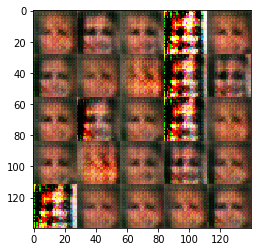

Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 2.0503
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 2.0176
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 3.4974
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 2.9512... Generator Loss: 4.0797
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 2.0594
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 2.0216
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 3.1407
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.4128


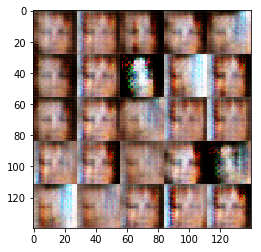

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 2.3465
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 0.7508


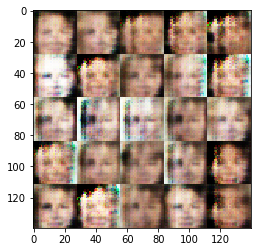

Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 2.3092
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.7854... Generator Loss: 3.4035
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.6627
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.4790
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6548


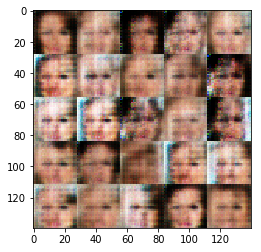

Epoch 1/1... Discriminator Loss: 2.7373... Generator Loss: 0.1351
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 2.0016... Generator Loss: 0.2494
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 2.4042... Generator Loss: 2.7826
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 2.6327
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 2.5235


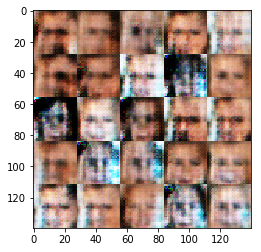

Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.5752


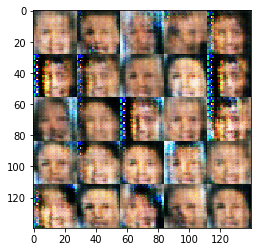

Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.9014
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 2.6074
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 2.2832


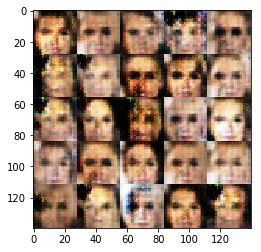

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 2.6519
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 1.5424
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 0.9912


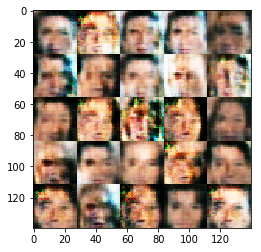

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.1109


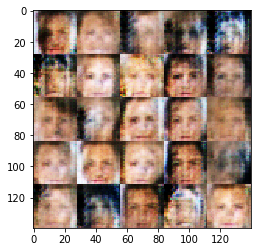

Epoch 1/1... Discriminator Loss: 1.9355... Generator Loss: 0.2139
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 1.4903
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.9915
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.8599
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.6671
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.4147
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.3509


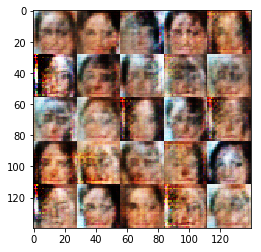

Epoch 1/1... Discriminator Loss: 2.1605... Generator Loss: 0.1917
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.8210


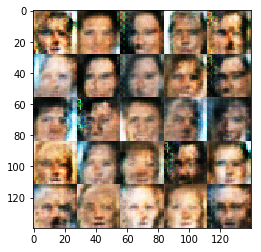

Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.2202
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 2.5739
Epoch 1/1... Discriminator Loss: 2.1242... Generator Loss: 3.7105
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.6875


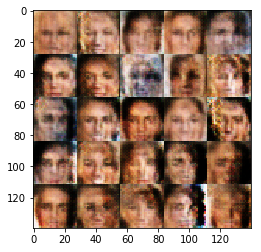

Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.6781


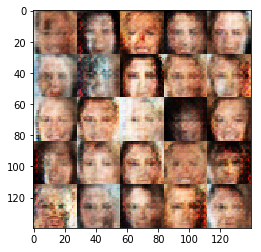

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.6017
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.9676


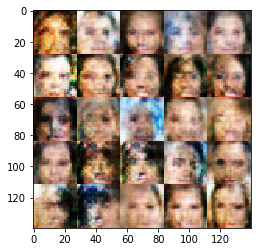

Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.8437
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.6803
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.6109


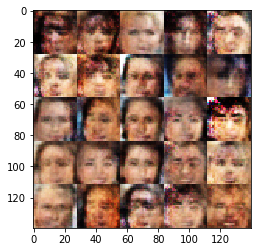

Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.7660
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.8699
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 2.0505
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.6711


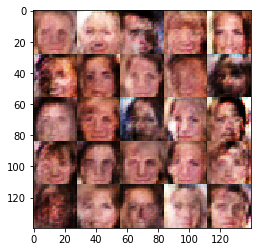

Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.7800
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.9242


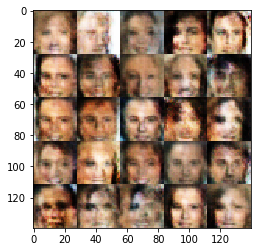

Epoch 1/1... Discriminator Loss: 2.2948... Generator Loss: 0.1598
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 2.0344
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.5902


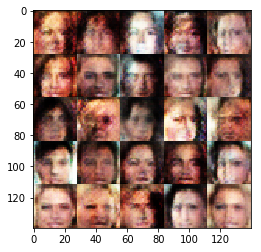

Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 2.1521
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.9498
Epoch 1/1... Discriminator Loss: 1.8218... Generator Loss: 0.2473
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6167


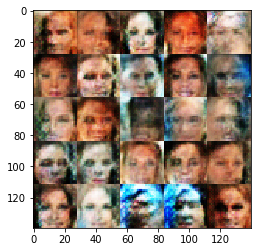

Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.9108... Generator Loss: 0.2369
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.3838
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0464


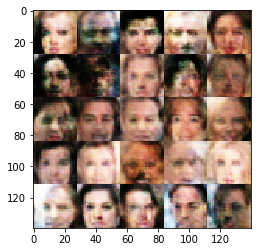

Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 1.4788
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.6215
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.5769


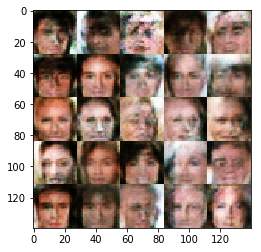

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.3999
Epoch 1/1... Discriminator Loss: 1.7357... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.5439


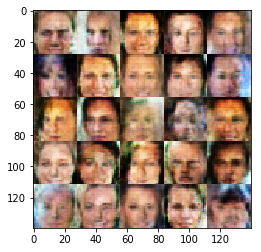

Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 3.3464
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.7615... Generator Loss: 2.3226
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.8097


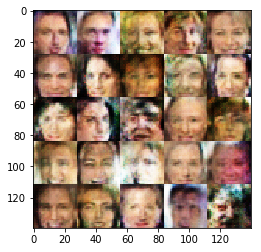

Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.7962
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 2.1727


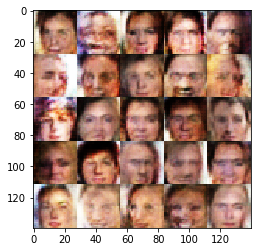

Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.3471
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.1828


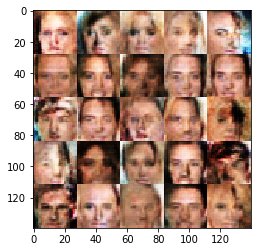

Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 2.5187
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.6674
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.4093
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.3993
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 0.8628


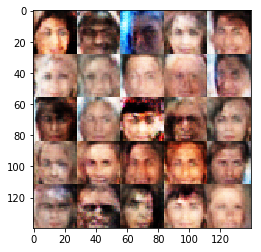

Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.9920


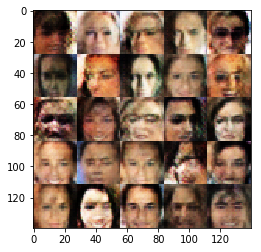

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.1791
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.9185
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.7387


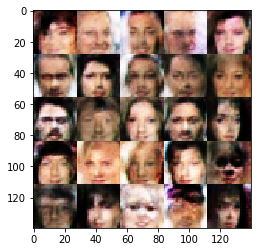

Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.1759


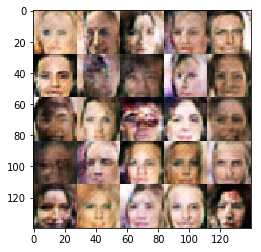

Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.9029
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.0048


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.